/var/folders/jj/9j0c_6196zx24tx5jb3ngnym0000gn/T/ipykernel_20896/1650857405.py:40: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = interval, period = PERIOD)
[*********************100%***********************]  1 of 1 completed


R^2: 0.002413360376792073
Coefficient: 0.010588072985385666
Intercept: -0.44147596907310094


Price,Close,High,Low,Open,Volume,Target,RSI,Predictions,Residuals
2894,364.646667,372.333344,356.906677,357.890015,71145900,-0.500028,54.657245,0.137239,-0.637266
2895,362.823334,373.000000,359.473328,369.829987,60324000,-0.209471,54.005058,0.130334,-0.339805
2896,362.063324,368.000000,354.713318,366.213318,56154000,-1.459227,51.942541,0.108495,-1.567722
2897,356.779999,365.183319,351.049988,353.776672,47040900,-1.266884,58.440305,0.177294,-1.444178
2898,352.260010,360.666656,351.529999,357.813324,40733700,13.531668,55.037897,0.141269,13.390399
...,...,...,...,...,...,...,...,...,...
3875,391.089996,402.799988,383.760010,402.320007,100460600,6.824517,26.390087,-0.162056,6.986573
3876,417.779999,421.720001,401.089996,402.170013,96806400,0.387763,42.035612,0.003600,0.384163
3877,419.399994,420.480011,405.950012,414.420013,71915600,1.711968,35.781409,-0.062620,1.774588
3878,426.579987,426.940002,416.890015,423.950012,63463000,0.841584,43.148789,0.015387,0.826197


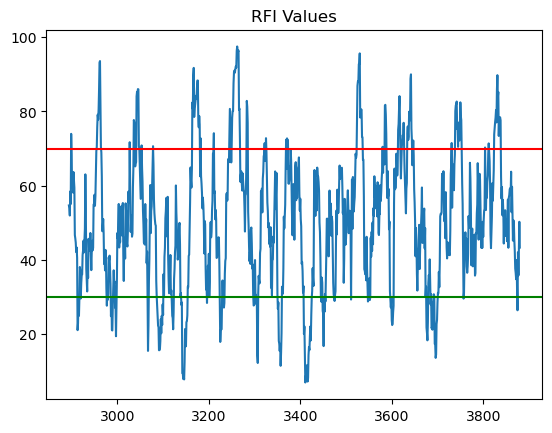

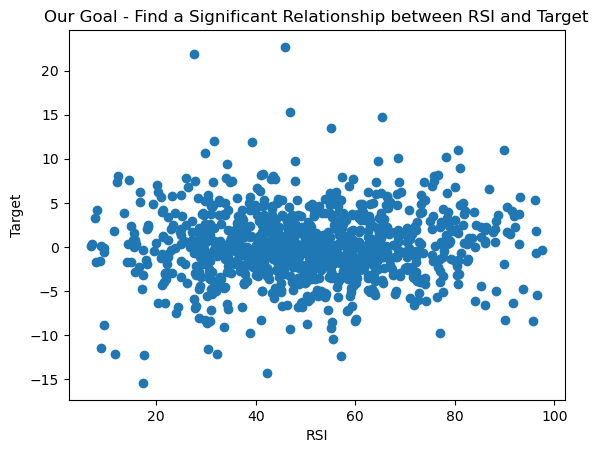

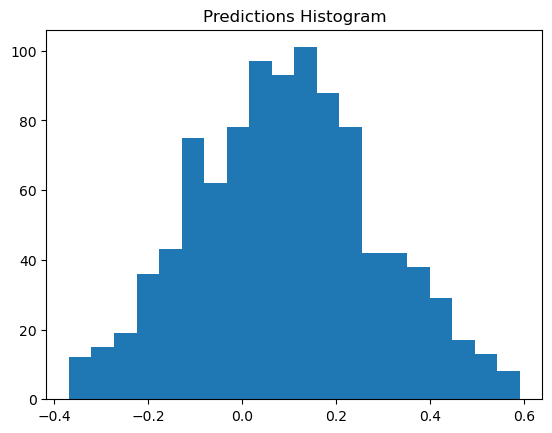

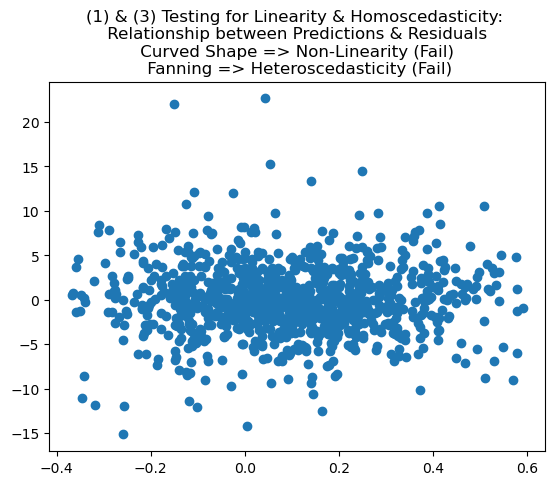

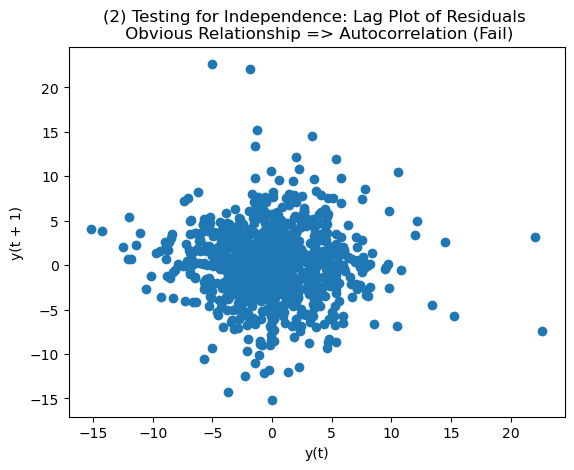

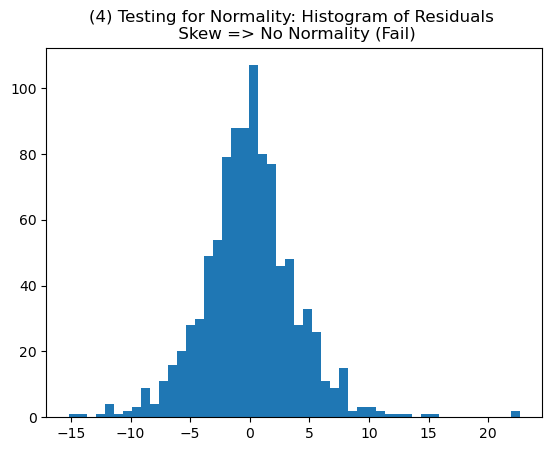

In [1]:
## We will change our Regresison Analysis to be able to Validate Regression Outpu all in one function

import numpy as np 
import pandas as pd
from pandas.plotting import lag_plot
import yfinance as yf
import matplotlib.pyplot as plt
import sklearn as sk

# --- (0) GLOBAL PARAMETERS ---

# Step 1: Ticker
TICKER = "TSLA"

# Step 2: Price Behavior
INTERVAL = "1d"
if INTERVAL == "1h":
    PERIOD = "730d"
else: 
    PERIOD = "max"

# Step 3: Strategy/Independet Variable (FGV)
STRATEGY = "RSI"

RSI_LENGTH = 14
RSI_OVERBROUGHT = 70
RSI_OVERSOLD = 30

# Step 4: shift days back for the calculation
SHIFT = 1

# Step 5: Data Subsction (How many rows will we analyze)
LOOKBACK = 1000

# --- (1) Download Data into df ---

def get_data(ticker = TICKER, interval = INTERVAL, lookback = LOOKBACK):

    # Step 1: Download Data
    df = yf.download(ticker, interval = interval, period = PERIOD)

    # Step 2: Select only Level 0 of Multilevel Columns
    df.columns = df.columns.get_level_values(0)

    # Step 3: Simplifying df for Plots (Index instead Datum)
    df = df.reset_index(drop=True)

    # Step 4: Return only LOOKBACK Rows
    return df.iloc[-lookback:, :]

# --- (2) Defining Dependent/Target Variable ---

def add_target(df, shift = SHIFT):

    # Step 1: Define Delta/Price Change (Tomorrow - Today), in percentage Terms * 100
    df["Target"] = (df["Close"].shift(-shift) - df["Close"])/df["Close"] * 100

    # Step 2: Return df 
    return df

# --- (3) Defining Independent/Features Variable ---

def add_RSI(df, length = RSI_LENGTH, overbrought = RSI_OVERBROUGHT, oversold = RSI_OVERSOLD):
    
    # Step 1: Define Delta/Price Change (Today - Yesterday)
    price_change = df["Close"].diff()

    # Step 2: Group Price Changes based on Positive/Ngeative Returns
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # Step 3: Calculate the Rolling Average for Length Days
    avg_gain = gain.rolling(window = length).mean()
    avg_loss = loss.rolling(window = length).mean()

    # Step 4: Calculate teh Relative Strength 
    rs = avg_gain / avg_loss

    # Step 5: Calculate the RSI w/ Standardization (Values between -100)
    df["RSI"] = 100 - (100/(1+rs))

     # Step 6: Plot the RSI
    plt.figure()
    plt.plot(df["RSI"])
    plt.title("RFI Values")

    # Step 7: Plot horizontal lines for Overbrought/Oversold
    plt.axhline(overbrought, color="red") # Crossing Overbrought Line: triggers Short Signal
    plt.axhline(oversold, color="green") # Crossing Oversold Line: triggers Long Signal
    
    return df.dropna()
    
# --- (4) Generate Regression Output ---

def generate_regression_output(df, features="RSI", target="Target"):
    # Use SciKit to understand whether RSI could be realted to future Price Movemnets
    # Metric: High R^2 Values

    # Step 1: Subset Data 
    subset = df[[features, target]].dropna()

    # Step 2: Reshape df from Series (Pandas) into Arry (Numpy) for Sklearn

        # Step 2.1.: [[features]]: selects df; .values: reshape df into 2D array
    X = subset[[features]].values
       
        # Step 2.2.: [target]: selects df; .values: reshape df into 1D array
    y = subset[target].values

    # Step 3: Build Model 
        
        # Step 3.1.: Creates Linear Regression Model Variable (Best Straight Line to describe Relationship)
    model = sk.linear_model.LinearRegression()

        # Step 3.2.: Feed the Model with Features & Target (Adjust slope, and Intercept to minimize the Distance between Y and Y_pred)
    model.fit(X,y)

    # Step 4: Use LR model to predict the target variable
    y_pred = model.predict(X)

    # Step 5: Quantify the Quality of the Relationship (How much of the dependent variable (actual price change, y) is predictable from the features (RSI, x))
    r2 = sk.metrics.r2_score(y, y_pred)
        # 1.0 (100%) Perfect Fit: Your RSI perfectly predicts the future price change. (Unlikely in trading).$
        # 0.2 (20%) Weak Fit: Your model explains 20% of the movement, and 80% is still unexplained noise.
        # 0.0 (0%) No Predictive Power: Your model is no better at predicting the outcome than simply using the historical average
        # In stats, the mean (average) is the simplest possible forecast that minimizes the sum of squared errors for any dataset
    print(f"R^2: {r2}")

    # Step 6: Visualize Coefficient and Intercept
    coefficient = model.coef_[0]
    print(f"Coefficient: {coefficient}")
    intercept = model.intercept_
    print(f"Intercept: {intercept}")

    # Step 7: Plot Scatter Plot for better Visualization of Patterns
    plt.figure()
    plt.title(f"Our Goal - Find a Significant Relationship between {features} and {target}")
    plt.scatter(X, y)
        # Goal: Recognize Direction in the Plot
    plt.xlabel(f"{features}")
    plt.ylabel(f"{target}")

    # Step 8: Visualie Linear Regression, Plot Predictions Histogram 
    df["Predictions"] = coefficient * df[[f"{STRATEGY}"]] + intercept
    plt.figure()
    plt.hist(df["Predictions"], bins = 20)
        # x-Achsis: Bins represent the range of predicted price changes (e.g., -1%, -0.5%, 0%, +0.5%)
        # y-Achsis: shows the count/number of times (the frequency) a data point fell into that specific bin
    plt.title("Predictions Histogram")

    return df

# --- (5) Validate Regression Output ---

def test_linearity_homoscedasticity(df):

    # Step 1: To test for Linearity (1) & Homoscedasticity (3) - Create Residuals Column & Scatter Plot it 
    df["Residuals"] = df["Target"] - df["Predictions"]
    plt.figure()
    plt.scatter(df["Predictions"], df["Residuals"])
    plt.title("(1) & (3) Testing for Linearity & Homoscedasticity: \n Relationship between Predictions & Residuals \n Curved Shape => Non-Linearity (Fail) \n Fanning => Heteroscedasticity (Fail)")

    return df

def test_independence(df):

    # Step 1: to test for Independence, plot Lag Plot
    plt.figure()
    lag_plot(df["Residuals"].dropna())
    plt.title("(2) Testing for Independence: Lag Plot of Residuals \n Obvious Relationship => Autocorrelation (Fail)")

    return

def test_normality(df):

    # Step 1: to test for Normality, plot Residuals Histogram 
    plt.figure()
    plt.hist(df["Residuals"], bins = 50)
    plt.title("(4) Testing for Normality: Histogram of Residuals \n Skew => No Normality (Fail)")

    return

def main():

    df = get_data()
    df = add_target(df)
    df = add_RSI(df)
    df = generate_regression_output(df)
    df = test_linearity_homoscedasticity(df)
    test_independence(df)
    test_normality(df)



    return df

df = main()
df


In [2]:
# Debugging 
print(type(df["Predictions"]))
print(df["Predictions"].head())

<class 'pandas.core.series.Series'>
2894    0.137239
2895    0.130334
2896    0.108495
2897    0.177294
2898    0.141269
Name: Predictions, dtype: float64
